In [1]:
# preferred public surface
import os, sys
sys.path.insert(0, os.path.abspath(".."))  # add repo root

from graphglue.core import IncidenceAdapter
from graphglue.adapters.networkx import to_backend, to_nx, from_nx


In [3]:
G = IncidenceAdapter()
G.add_vertex("A")
G.add_vertex("B")
G.add_edge({"A"}, {"B"})  # uses BaseGraph semantics
list(G.deep.edge_definitions.items())
G.deep.add_layer("t0")
G.deep.set_layer_edge_weight("t0", "edge_0", 2.0)

In [5]:
# demo_adapter.py

print("=== Basic graph creation ===")
G = IncidenceAdapter()
G.add_vertex("A")
G.add_vertex("B")
eidx = G.add_edge({"A"}, {"B"})
print("Vertices:", list(G.V))
print("Edges (index, (s,t)):", list(G.edges()))
print("Number of vertices:", G.num_vertices)
print("Number of edges:", G.num_edges)
print("Shape (|V|,|E|):", G.shape)
print()

print("=== Accessing edge info ===")
s, t = G.get_edge(eidx)
print("Edge definition:", s, "->", t)
print()

print("=== BFS / Successors / Neighbors ===")
G.add_vertex("C")
G.add_edge({"B"}, {"C"})
layers = G.bfs("A")
print("BFS layers from A:", layers)
print("Successors(A):", list(G.successors("A")))
print("Predecessors(C):", list(G.predecessors("C")))
print("Neighbors(B):", list(G.neighbors_exclusive("B")))
print()

print("=== Subgraph and prune ===")
SG = G.edge_subgraph([0])  # keep only first edge
print("Edge-subgraph edges:", list(SG.edges()))
P = G.prune(source=["A"], target=["C"])
print("Pruned graph edges:", list(P.edges()))
print

print("=== Deep access: layers and per-layer weights ===")
D = IncidenceAdapter()
D.deep.add_layer("t0")
e = D.add_edge({"A"}, {"B"}, weight=1.5, label="ab")
eid = D.deep.idx_to_edge[e]
# attach same edge to layer
w = D.deep.edge_weights[eid]
D.deep.add_edge("A", "B", layer="t0", edge_id=eid, edge_directed=True, weight = w)
D.deep.set_layer_edge_weight("t0", eid, 2.0)

print("Edge definitions:", list(D.deep.edge_definitions.items()))
print("Global edge weight:", D.deep.edge_weights[eid])
print("Layer t0 weight:", D.deep.get_effective_edge_weight(eid, layer="t0"))
print("Layers containing edge:", D.deep.edge_presence_across_layers(eid, include_default=True))


=== Basic graph creation ===
Vertices: ['A', 'B']
Edges (index, (s,t)): [(0, (frozenset({'A'}), frozenset({'B'})))]
Number of vertices: 2
Number of edges: 1
Shape (|V|,|E|): (2, 1)

=== Accessing edge info ===
Edge definition: frozenset({'A'}) -> frozenset({'B'})

=== BFS / Successors / Neighbors ===
BFS layers from A: {'A': 0, 'B': 1, 'C': 2}
Successors(A): ['B']
Predecessors(C): ['B']
Neighbors(B): ['A', 'C']

=== Subgraph and prune ===
Edge-subgraph edges: [(0, (frozenset({'A'}), frozenset({'B'})))]
Pruned graph edges: [(0, (frozenset({'A'}), frozenset({'B'}))), (1, (frozenset({'B'}), frozenset({'C'})))]
=== Deep access: layers and per-layer weights ===
Edge definitions: [('edge_0', ('A', 'B', 'regular'))]
Global edge weight: 1.5
Layer t0 weight: 2.0
Layers containing edge: ['default', 't0']


In [7]:
print("=== Incidence matrix with per-vertex coefficients ===")
H = IncidenceAdapter()
H.add_vertices(["X", "Y"])
H.add_edge({"X": 3}, {"Y": 2})
mat = H.vertex_incidence_matrix(values=True, sparse=False)
print("Vertices:", list(H.V))
print("Incidence matrix:\n", mat)

=== Incidence matrix with per-vertex coefficients ===


KeyError: '__source_attr'

In [10]:
G = IncidenceAdapter()
G.add_vertices(["A", "B", "C"])
G.add_edge({"A"}, {"B"}, weight=2.0)
G.add_edge({"B"}, {"C"}, weight=3.0)

1

Nodes: [('A', {}), ('B', {}), ('C', {})]
Edges: [('A', 'B', {'__edge_type': 'DIRECTED', '__weight': 2.0}), ('B', 'C', {'__edge_type': 'DIRECTED', '__weight': 3.0})]


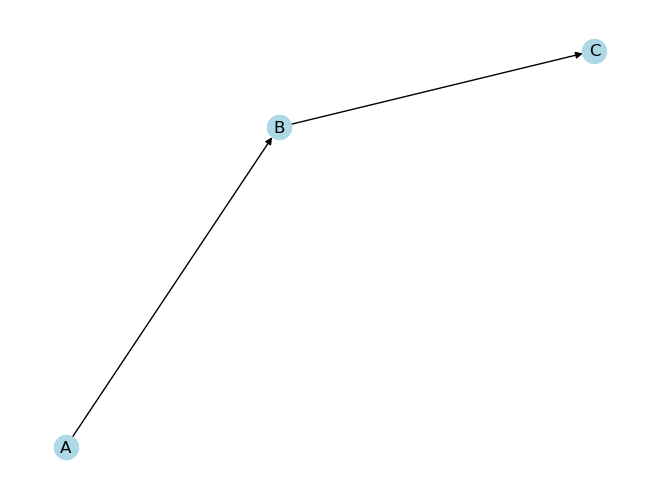

In [12]:
# convert to a networkx graph
import networkx as nx
nxG = to_backend(G, directed=True)  # or directed=False if you prefer

print("Nodes:", nxG.nodes(data=True))
print("Edges:", nxG.edges(data=True))

# quick visualization
import matplotlib.pyplot as plt
pos = nx.spring_layout(nxG)
nx.draw(nxG, pos, with_labels=True, node_color="lightblue")
nx.draw_networkx_edge_labels(nxG, pos, edge_labels=nx.get_edge_attributes(nxG, "weight"))
plt.show()

In [14]:
nxG, man = to_nx(G, directed=True, hyperedge_mode="skip")


In [16]:

H2 = from_nx(nxG, man)
print(list(H2.edges()))


[(0, (frozenset({'A'}), frozenset({'B'}))), (1, (frozenset({'B'}), frozenset({'C'})))]


In [18]:
for eid, (s, t) in H2.edges():
    print(eid, s, t, H2.get_attr_edge(eid))


0 frozenset({'A'}) frozenset({'B'}) {'__edge_type': 'DIRECTED', '__weight': 2.0}
1 frozenset({'B'}) frozenset({'C'}) {'__edge_type': 'DIRECTED', '__weight': 3.0}


In [20]:
print(H2.deep.node_attributes.head())  # attrs present
print(H2.deep.edge_attributes.head())    # attrs present


shape: (0, 1)
┌─────────┐
│ node_id │
│ ---     │
│ str     │
╞═════════╡
└─────────┘
shape: (2, 3)
┌─────────┬─────────────┬──────────┐
│ edge_id ┆ __edge_type ┆ __weight │
│ ---     ┆ ---         ┆ ---      │
│ str     ┆ str         ┆ f64      │
╞═════════╪═════════════╪══════════╡
│ edge_0  ┆ DIRECTED    ┆ 2.0      │
│ edge_1  ┆ DIRECTED    ┆ 3.0      │
└─────────┴─────────────┴──────────┘


In [24]:
H2.deep.edge_attributes.head()

edge_id,__edge_type,__weight
str,str,f64
"""edge_0""","""DIRECTED""",2.0
"""edge_1""","""DIRECTED""",3.0


In [28]:
from graphglue.utils.plotting import plot, render

G = IncidenceAdapter()
G.add_vertices(["A","B","C"])
G.add_edge({"A"}, {"B"}, weight=2.5, label="ab")
G.add_edge({"B"}, {"C"}, weight=-1.3, label="bc")
G.deep.add_layer("L1")
# attach AB to L1 with heavier per-layer weight
eid = G.deep.idx_to_edge[0]
G.deep.add_edge("A","B", layer="L1", edge_id=eid, edge_directed=True)
G.deep.set_layer_edge_weight("L1", eid, 4.0)




In [30]:
import os
graphviz_path = r"C:\Program Files\Graphviz\bin"
if graphviz_path not in os.environ["PATH"]:
    os.environ["PATH"] += os.pathsep + graphviz_path

from graphviz import Digraph

In [32]:
# 1) quick graphviz view (layer-aware weights, with edge labels)
g = plot(G, backend="graphviz", layer="L1",
         show_edge_labels=True, edge_label_keys=["label"],
         show_vertex_labels=True, use_weight_style=True)


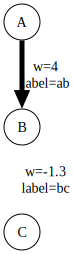

In [34]:
g

In [36]:
from graphglue.adapters.igraph import to_igraph, from_igraph, save_manifest, load_manifest

In [38]:
igG, manifest = to_igraph(G, directed=True, hyperedge_mode="skip", public_only=False)
H = from_igraph(igG, manifest)

In [40]:
igGp = plot(H, backend="graphviz", layer="L1",
         show_edge_labels=True, edge_label_keys=["label"],
         show_vertex_labels=True, use_weight_style=True)


In [42]:
H